**GOAL** :

- Load text feature (name + description)
- pre-process (tokenize + filter tokens)
- fit and evaluate several clustering models.

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import project_tools as pt
import data_science_functions as ds

import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')
nltk.download('wordnet')

# Define collection of words/tokens
stopwords = nltk.corpus.stopwords.words('english')
correct_words = set(nltk.corpus.words.words())
# Define lemmatizer and stemmer
lemmatizer = nltk.stem.WordNetLemmatizer()
porter = nltk.stem.PorterStemmer()
lancaster = nltk.stem.LancasterStemmer()

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline

from collections import defaultdict
from sklearn import metrics
from time import time

from wordcloud import WordCloud

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

# Very convenient script from sklearn
evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/louberehc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/louberehc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/louberehc/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/louberehc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Table of contents**<a id='toc0_'></a>    
- 1. [(name + description) pre-processing](#toc1_)    
  - 1.1. [Load the data](#toc1_1_)    
  - 1.2. [Tokenization](#toc1_2_)    
  - 1.3. [Exploring regex to do that.](#toc1_3_)    
  - 1.4. [Tokens exploration](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>(name + description) pre-processing

## 1.1.  [&#9650;](#toc0_) <a id='toc1_1_'></a>Load the data

In [5]:
df = (
    pd.read_csv('text_data.csv.gz', index_col='product_id')
    .drop('name', axis=1)
)
df.shape

(1050, 2)

In [15]:
df.head(2)

,description,category
product_id,,
55b85ea15a1536d46b7190ad6fff8ce7,"Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you get the right amount of sunlight.,Specifications of Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) General Brand Elegance Designed For Door Type Eyelet Model Name Abstract Polyester Door Curtain Set Of 2 Model ID Duster25 Color Multicolor Dimensions Length 213 cm In the Box Number of Contents in Sales Package Pack of 2 Sales Package 2 Curtains Body & Design Material Polyester",home_furnishing
7b72c92c2f6c40268628ec5f14c6d590,"Sathiyas Cotton Bath Towel. Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Self Design General Brand Sathiyas Type Bath Towel GSM 500 Model Name Sathiyas cotton bath towel Ideal For Men, Women, Boys, Girls Model ID asvtwl322 Color Red, Yellow, Blue Size Mediam Dimensions Length 30 inch Width 60 inch In the Box Number of Contents in Sales Package 3 Sales Package 3 Bath Towel",baby_care


## 1.2.  [&#9650;](#toc0_) <a id='toc1_2_'></a> First tokenization

In [13]:
def tokenize_description(description: str, rejoin: bool=False)-> list:
    """ A soft tokenizer accepting a lot of tokens. """

    # Define tokens we want to filter in the word_tokenize() result.
    useless_tokens = ["'s", "''"]
    undesired_tokens = [*useless_tokens,
                        *string.punctuation,
                        *stopwords,]
    
    # Tokenize and lower case.
    tokens = nltk.word_tokenize(description)
    tokens = [token.lower() for token in tokens]
    # Filter undesired tokens
    tokens = [token
              for token in tokens
              if token not in undesired_tokens]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    if rejoin:
        tokens = ' '.join(tokens)

    return tokens

In [17]:
example = df.description[0]
example

'Elegance Polyester Multicolor Abstract Eyelet Door Curtain. Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegan

In [14]:
tokenize_description(example)

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 '213',
 'cm',
 'height',
 'pack',
 '2',
 'price',
 'r',
 '899',
 'curtain',
 'enhances',
 'look',
 'interiors.this',
 'curtain',
 'made',
 '100',
 'high',
 'quality',
 'polyester',
 'fabric.it',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring.it',
 'make',
 'room',
 'environment',
 'romantic',
 'loving.this',
 'curtain',
 'ant-',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance.give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want

Here we see that we need to introduce blank spaces at the start of sentences to avoid the problem above (if we find a capital letter after a point.)

But let's try the sentence tokenizer beforehand to see if it catches that problem.


In [18]:
nltk.sent_tokenize(example)

['Elegance Polyester Multicolor Abstract Eyelet Door Curtain.',
 'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs.',
 '899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs.',
 'The surreal attention is sure to steal hearts.',
 'These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints.',
 '

## 1.3.  [&#9650;](#toc0_) <a id='toc1_3_'></a>Exploring regex to address the punction-capital problem.

In [22]:
import re

In [58]:
test = 'Will I catch it.Not sure ?Now is the http://useless.com, second one.It works I dunno'

In [59]:
regex = '([.])([A-Z])'
matches = re.finditer(regex, test)


In [60]:
for match in matches:
    print(match)
    print(match.group(2))

<re.Match object; span=(15, 17), match='.N'>
N
<re.Match object; span=(67, 69), match='.I'>
I


In [61]:
re.sub(regex, r"\1 \2", test)

'Will I catch it. Not sure ?Now is the http://useless.com, second one. It works I dunno'

In [62]:
regex = '([.?,!])([A-Z])'
matches = re.finditer(regex, test)
re.sub(regex, r"\1 \2", test)

'Will I catch it. Not sure ? Now is the http://useless.com, second one. It works I dunno'

In [57]:
test

'Will I catch it.Not sure ?Now is the second one.It works I dunno'

In [67]:
pt.tokenize_description(example)

['elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'key',
 'feature',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'elegance',
 'polyester',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 '213',
 'cm',
 'height',
 'pack',
 '2',
 'price',
 'r',
 '899',
 'curtain',
 'enhances',
 'look',
 'interior',
 'curtain',
 'made',
 '100',
 'high',
 'quality',
 'polyester',
 'fabric',
 'feature',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'make',
 'room',
 'environment',
 'romantic',
 'loving',
 'curtain',
 'ant-',
 'wrinkle',
 'anti',
 'shrinkage',
 'elegant',
 'apparance',
 'give',
 'home',
 'bright',
 'modernistic',
 'appeal',
 'design',
 'surreal',
 'attention',
 'sure',
 'steal',
 'heart',
 'contemporary',
 'eyelet',
 'valance',
 'curtain',
 'slide',
 'smoothly',
 'draw',
 'apart',
 'first',
 'thing',
 'morning',
 'welcome',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 

In [68]:
pt.tokenize_description(example, rejoin=True)

'elegance polyester multicolor abstract eyelet door curtain key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 price r 899 curtain enhances look interior curtain made 100 high quality polyester fabric feature eyelet style stitch metal ring make room environment romantic loving curtain ant- wrinkle anti shrinkage elegant apparance give home bright modernistic appeal design surreal attention sure steal heart contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight. specification elegance polyester multicolor abstract eyelet door curtain 213 cm height pack 2 general brand elegance designed door type eyelet model name abstract polyester door cu

## 1.4.  [&#9650;](#toc0_) <a id='toc1_4_'></a>Tokens exploration

In [69]:
df['description_tokens'] = df.description.apply(pt.tokenize_description)

In [73]:
df['n_tokens'] = df.description_tokens.apply(lambda x: len(x))

In [75]:
df['n_unique_tokens'] = (
    df.description_tokens
    .apply(
        lambda x: np.unique(np.asarray(x)).shape[0]
    )
)

In [78]:
df.sample(10)

,description,category,description_tokens,n_tokens,n_unique_tokens
product_id,,,,,
b4ccd4c315d99edd7c00d015b714485a,"Famous Wheel Pizza Cutter. Famous Wheel Pizza Cutter (Steel Pack of 1)\r\n Price: Rs. 299\r\n\t\t\t\t\r\n\t\t\tPizza Cutter With Extra Shape Blade. Brand New And High Quality. Perfectly Designed Pizza Cutter For Pizza, Sandwich, Garlic Bread, Pastry . Performance With Easy Operation & Sharp Edge. Perfect Grip While . High Quality . Compact Size And Light Weight For Convenient Use. New Stylish Pizza Cutter- Cut Pizza With Great Ease Blade Made Of High Quality Stainless Steel Handle Made Of High Quality Plastic Scientifically Designed For Effort Less Cutting Durable Portable And Easy To Carry Beautiful And Stylish Model May Vary According To Availability Pizza Cutter Slicer Perfectly Designed Pizza Cutter For Optimum Perfect Grip While Cutting Pizza Cutter With Extra Sharp Blade Best Grip For Holding And Cutting Compact Size And Light Weight For Convenient Use.\r\nPizza Cutter With Extra Shape Blade. Brand New And High Quality. Perfectly Designed Pizza Cutter For Pizza, Sandwich, Garlic Bread, Pastry . Performance With Easy Operation & Sharp Edge. Perfect Grip While . High Quality . Compact Size And Light Weight For Convenient Use. New Stylish Pizza Cutter- Cut Pizza With Great Ease Blade Made Of High Quality Stainless Steel Handle Made Of High Quality Plastic Scientifically Designed For Effort Less Cutting Durable Portable And Easy To Carry Beautiful And Stylish Model May Vary According To Availability Pizza Cutter Slicer Perfectly Designed Pizza Cutter For Optimum Perfect Grip While Cutting Pizza Cutter With Extra Sharp Blade Best Grip For Holding And Cutting Compact Size And Light Weight For Convenient Use.",kitchen_&_dining,"[famous, wheel, pizza, cutter, famous, wheel, pizza, cutter, steel, pack, 1, price, r, 299, pizza, cutter, extra, shape, blade, brand, new, high, quality, perfectly, designed, pizza, cutter, pizza, sandwich, garlic, bread, pastry, performance, easy, operation, sharp, edge, perfect, grip, high, quality, compact, size, light, weight, convenient, use, new, stylish, pizza, cutter-, cut, pizza, great, ease, blade, made, high, quality, stainless, steel, handle, made, high, quality, plastic, scientifically, designed, effort, le, cutting, durable, portable, easy, carry, beautiful, stylish, model, may, vary, according, availability, pizza, cutter, slicer, perfectly, designed, pizza, cutter, optimum, perfect, grip, cutting, pizza, cutter, extra, sharp, blade, best, grip, ...]",202,62
cdf4aedfc9420a2e212fb64e2688bcdc,"King Traders KI-BD-01 1 Kitchen Tool Set. King Traders KI-BD-01 1 Kitchen Tool Set Price: Rs. 582 We are counted amongst the trusted names in manufacturing an exclusive range of Butter Dish Pot for Hotels. These Butter Dish Pot are widely used in various Hotels. Our offered range of Butter Dish Pots can be availed at very economical prices. Features: Impeccable finish Long service life Easy to use Dimension : 14.5 X 12 X 8 cm Weight: 200 gram Capacity:1/4 kg"",Specifications of King Traders KI-BD-01 1 Kitchen Tool Set General Brand King Traders Model Number KI-BD-01 Type Butter Dish /Pot Material Stainless Steel Color 1 In the Box Sales Package 1Butter Dish /Pot Pack of 1",kitchen_&_dining,"[king, trader, ki-bd-01, 1, kitchen, tool, set, king, trader, ki-bd-01, 1, kitchen, tool, set, price, r, 582, counted, amongst, trusted, name, manufacturing, exclusive, range, butter, dish, pot, hotel, butter, dish, pot, widely, used, various, hotel, offered, range, butter, dish, pot, availed, economical, price, feature, impeccable, finish, long, service, life, easy, use, dimension, 14.5, x, 12, x, 8, cm, weight, 200, gram, capacity:1/4, kg, specification, king, trader, ki-bd-01, 1, kitchen, tool, set, general, brand, king, trader, model, number, ki-bd-01, type, butter, dish, /pot, material, stainless, steel, color, 1, box, sale, package, 1butter, dish, /pot, pack, 1]",95,62
4e03d4e81e6a876f512536f6a5

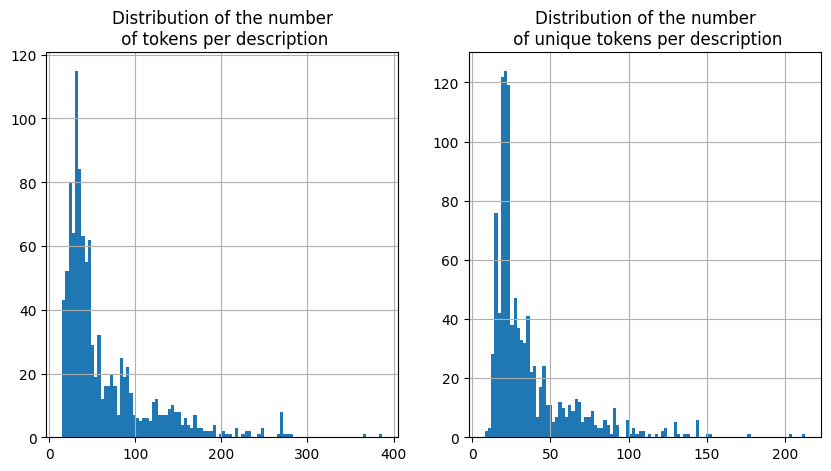

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

df.n_tokens.hist(ax=ax[0], bins=100,)
ax[0].set_title("Distribution of the number\n of tokens per description")


df.n_unique_tokens.hist(ax=ax[1], bins=100,)
ax[1].set_title("Distribution of the number\n of unique tokens per description")
plt.show()

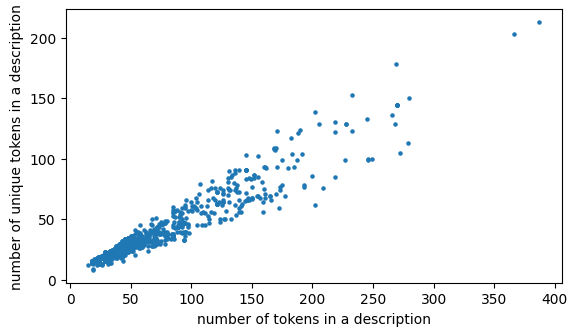

In [98]:
fig, ax = plt.subplots(1,1)
ax.scatter(df.n_tokens, df.n_unique_tokens, s=5)
ax.set_aspect('equal')
ax.set_xlabel('number of tokens in a description')
ax.set_ylabel('number of unique tokens in a description')
plt.show()

In [101]:
(df.n_unique_tokens / df.n_tokens).mean()

0.6174773239840637

In [102]:
df.n_unique_tokens.describe()

count    1050.000000
mean       35.918095
std        26.071087
min         8.000000
25%        20.000000
50%        25.000000
75%        40.000000
max       213.000000
Name: n_unique_tokens, dtype: float64

In [106]:
df.query('n_unique_tokens < 13')

,description,category,description_tokens,n_tokens,n_unique_tokens
product_id,,,,,
84b2e623a4a4327b88f7fe197a09be31,Next Steps Baby Girl's Layered Dress. Next Steps Baby Girl's Layered Dress\r\n Price: Rs. 356\r\n\t\t\t\t\r\n\t\t\tGirls Dress\r\nGirls Dress,baby_care,"[next, step, baby, girl, layered, dress, next, step, baby, girl, layered, dress, price, r, 356, girl, dress, girl, dress]",19,9
227fc5c4fca14c424ff33e40941d22fa,MyKid Nappy. Flipkart.com is offering MyKid Nappy for only for Rs 199 | Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!,baby_care,"[mykid, nappy, flipkart.com, offering, mykid, nappy, r, 199, flipkart.com, genuine, product, free, shipping, cash, delivery]",15,12
159b45e4dede207f28319bf1cacee3bc,"MSenterprises Floral Cushions Cover. MSenterprises Floral Cushions Cover (Pack of 5, 40 cm*40 cm, Brown)\r\n Price: Rs. 580\r\n\t\t\t\t\r\n\t\t\tPack Of 5 Cushion Cover\r\nPack Of 5 Cushion Cover",home_furnishing,"[msenterprises, floral, cushion, cover, msenterprises, floral, cushion, cover, pack, 5, 40, cm, 40, cm, brown, price, r, 580, pack, 5, cushion, cover, pack, 5, cushion, cover]",26,12
b6c4cb6a29dcbaf7fa958f04c8215547,"Sassoon Cotton Bath Towel. Sassoon Cotton Bath Towel (Red)\r\n Price: Rs. 1,299\r\n\t\t\t\t\r\n\t\t\tFerrari Printed Towel 75x150cm-Design No.472\r\nFerrari Printed Towel 75x150cm-Design No.472",home_furnishing,"[sassoon, cotton, bath, towel, sassoon, cotton, bath, towel, red, price, r, 1,299, ferrari, printed, towel, 75x150cm-design, no.472, ferrari, printed, towel, 75x150cm-design, no.472]",22,12
d79e6ae847a561c284a2b14e42500698,Pedrini Steel Waiters Corkscrew. Pedrini Steel Waiters Corkscrew\r\n Price: Rs. 300\r\n\t\t\t\t\r\n\t\t\tPedrini Waiter CorkScrew With Knife\r\nPedrini Waiter CorkScrew With Knife,kitchen_&_dining,"[pedrini, steel, waiter, corkscrew, pedrini, steel, waiter, corkscrew, price, r, 300, pedrini, waiter, corkscrew, knife, pedrini, waiter, corkscrew, knife]",19,8


In [107]:
df.sample(5)

,description,category,description_tokens,n_tokens,n_unique_tokens
product_id,,,,,
ed139e0d1b5c973495e1aa35dd4a5533,JSM Hard Anodized Kadhai 4 L. Buy JSM Hard Anodized Kadhai 4 L for Rs.1071 online. JSM Hard Anodized Kadhai 4 L at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.,kitchen_&_dining,"[jsm, hard, anodized, kadhai, 4, l., buy, jsm, hard, anodized, kadhai, 4, l, rs.1071, online, jsm, hard, anodized, kadhai, 4, l, best, price, free, shipping, cash, delivery, genuine, product, 30, day, replacement, guarantee]",33,22
112a8a56ee40ee31ea06fb7ff23b5c25,meSleep Animal Cushions Cover. Buy meSleep Animal Cushions Cover at Rs. 699 at Flipkart.com. Only Genuine Products. Free Shipping. Cash On Delivery!,home_furnishing,"[mesleep, animal, cushion, cover, buy, mesleep, animal, cushion, cover, r, 699, flipkart.com, genuine, product, free, shipping, cash, delivery]",18,14
4e130ed339dcfe20d2c8b66892278a94,"Treasure Showpiece - 23 cm. Key Features of Treasure Showpiece - 23 cm Polyresin Height - 23 cm Width - 1 cm,Specifications of Treasure Showpiece - 23 cm (Polyresin, Blue) General Brand Treasure Model Number TE6 Type Fengshui Material Polyresin Color Blue Dimensions Height 23 cm Width 1 cm Depth 1 cm In the Box Sales Package 1 show piece",home_decor_&_festive_needs,"[treasure, showpiece, 23, cm, key, feature, treasure, showpiece, 23, cm, polyresin, height, 23, cm, width, 1, cm, specification, treasure, showpiece, 23, cm, polyresin, blue, general, brand, treasure, model, number, te6, type, fengshui, material, polyresin, color, blue, dimension, height, 23, cm, width, 1, cm, depth, 1, cm, box, sale, package, 1, show, piece]",52,28
a7a294ddbcd9bbbc46c034079529c17c,Wild Stone Deodorant No-22 Combo Set. Wild Stone Deodorant No-22 Combo Set (Set of 2)\r\n Price: Rs. 356\r\n\t\t\t\t\r\n\t\t\tLong lasting fragrance\r\nContains tricolosan as an active ingredient for deodorizing and long lasting fragrance\r\nLong lasting fragrance\r\nContains tricolosan as an active ingredient for deodorizing and long lasting fragrance,beauty_and_personal_care,"[wild, stone, deodorant, no-22, combo, set, wild, stone, deodorant, no-22, combo, set, set, 2, price, r, 356, long, lasting, fragrance, contains, tricolosan, active, ingredient, deodorizing, long, lasting, fragrance, long, lasting, fragrance, contains, tricolosan, active, ingredient, deodorizing, long, lasting, fragrance]",39,18
4cc971d2c9c0f1056bc124031ed52c1e,"Lock&Lock Kitchen - 5.5 L Polypropylene Multi-purpose Storage Container. Key Features of Lock&Lock Kitchen - 5.5 L Polypropylene Multi-purpose Storage Container Airtight Pack of 6,Lock&Lock Kitchen - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) Price: Rs. 2,145 Flexible Silicone Seal Ensures Precision Lid Fitting.Large Locking Hinges For Easy Open And Closing Movement.Fridge And Freezer Safe,Specifications of Lock&Lock Kitchen - 5.5 L Polypropylene Multi-purpose Storage Container (Pack of 6, Clear) General Brand Lock&Lock Model Number HPL816X3,HPL806X2,HPL836 Disposable No Model Name Kitchen Material Polypropylene Airtight Yes Capacity 5.5 L Container Type Multi-purpose Storage Container Color Clear In the box Sales Package 6 CONTAINER Pack of 6 Warranty Covered in Warranty Manufacturing Defects Warranty Summary 1 year warranty on manufacturing defects. Warranty Service Type Customer Care Not Covered in Warranty Accidental Damages",kitchen_&_dining,"[lock, lock, kitchen, 5.5, l, polypropylene, multi-purpose, storage, container, key, feature, lock, lock, kitchen, 5.5, l, polypropylene, multi-purpose, storage, container, airtight, pack, 6, lock, lock, kitchen, 5.5, l, polypropylene, multi-purpose, storage, container, pack, 6, clear, price, r, 2,145, flexible, silicone, seal, ensures, precision, lid, fitting, large, locking, hinge, easy, open, closing, movement, fridge, freezer, safe, specification, lock, lock, kitchen, 5.5, l, polypropylene, multi-purpose, storage, c

In [108]:
df.sample(5)

,description,category,description_tokens,n_tokens,n_unique_tokens
product_id,,,,,
fda0890dba67c93a7c80b0993651caec,"Ollington St. Collection Baby Reusable Diaper With One Insert. Ollington St. Collection Baby Reusable Diaper With One Insert\r\n Price: Rs. 599\r\n\t\t\t\t\r\n\t\t\tForm fitting and reusable Ollington St. diaper and inserts set for your baby.\r\n\r\nFeatures:\r\n-Reusable diapers\r\n-Snap closure adjusts to fit all sizes\r\n-Trim, snug and comfortable\r\n-Keeps your little one stain and irritation free\r\n-A front panel to insert disposable pad\r\n-Includes 1 reusable insert\r\n-Material: Polyester and PU\r\n-One size diaper\r\n-Available Colours: Green,Pink,Red,Turquoise Blue,Blue,Dark Blue\r\n-Sizes: Diaper-23 x 19 cms (Approx.), Insert- 34 x 13 cms (Approx.)\r\n\r\nWash Instructions:\r\n-Wash before first use\r\n-Wash upto 60 degree Celsius\r\n-Avoid fabric softener or bleach\r\n-Tumble dry or line dry\r\n-Age group: 0 to 36 months\r\nForm fitting and reusable Ollington St. diaper and inserts set for your baby.\r\n\r\nFeatures:\r\n-Reusable diapers\r\n-Snap closure adjusts to fit all sizes\r\n-Trim, snug and comfortable\r\n-Keeps your little one stain and irritation free\r\n-A front panel to insert disposable pad\r\n-Includes 1 reusable insert\r\n-Material: Polyester and PU\r\n-One size diaper\r\n-Available Colours: Green,Pink,Red,Turquoise Blue,Blue,Dark Blue\r\n-Sizes: Diaper-23 x 19 cms (Approx.), Insert- 34 x 13 cms (Approx.)\r\n\r\nWash Instructions:\r\n-Wash before first use\r\n-Wash upto 60 degree Celsius\r\n-Avoid fabric softener or bleach\r\n-Tumble dry or line dry\r\n-Age group: 0 to 36 months",baby_care,"[ollington, st., collection, baby, reusable, diaper, one, insert, ollington, st., collection, baby, reusable, diaper, one, insert, price, r, 599, form, fitting, reusable, ollington, st., diaper, insert, set, baby, feature, -reusable, diaper, -snap, closure, adjusts, fit, size, -trim, snug, comfortable, -keeps, little, one, stain, irritation, free, -a, front, panel, insert, disposable, pad, -includes, 1, reusable, insert, -material, polyester, pu, -one, size, diaper, -available, colour, green, pink, red, turquoise, blue, blue, dark, blue, -sizes, diaper-23, x, 19, cm, approx, insert-, 34, x, 13, cm, approx, wash, instruction, -wash, first, use, -wash, upto, 60, degree, celsius, -avoid, fabric, softener, bleach, -tumble, dry, line, ...]",193,78
13de17e59a92f8bcaec8bf103bbff8c1,"Go Bonjour Stainless Steel 9 pc Manicure Kit. Flipkart.com: Buy Go Bonjour Stainless Steel 9 pc Manicure Kit for Rs. 580 from Flipkart.com. - Lowest Prices, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!",beauty_and_personal_care,"[go, bonjour, stainless, steel, 9, pc, manicure, kit, flipkart.com, buy, go, bonjour, stainless, steel, 9, pc, manicure, kit, r, 580, flipkart.com, lowest, price, genuine, product, 30, day, replacement, guarantee, free, shipping, cash, delivery]",33,24
8141b9d5af35017a907b1e88c17f7963,"PRINT SHAPES roronoa Zora Laptop Skin with Mouse pad Combo Set. Key Features of PRINT SHAPES roronoa Zora Laptop Skin with Mouse pad Combo Set Glue Free Removal 15.6 inches Laptop skin Easy to Apply & Scratch Resistant Lamination,PRINT SHAPES roronoa Zora Laptop Skin with Mouse pad Combo Set (Multicolor) Price: Rs. 329 Print Shapes Laptop skin made on High Quality vinyl sheet is compatible with laptops screen sizes ranging from 14.1 inches to 15.6 inches. Trimning of the skin would be required as per your laptop size. The skins are easy to install & remove without leaving any gum or residue,Specifications of PRINT SHAPES roronoa Zora Laptop Skin with Mouse pad Combo Set (Multicolor) General Brand PRINT SHAPES Model Name roronoa Zora Laptop Skin with Mouse pad Suitable_for All types of Laptop Color Multicolor Warranty Warranty Summary No Warranty In the Box Number of Contents in Sales Package Pack of 2",computers,"[print, shape, roronoa, zora, laptop, skin, mouse, pad, combo, set, k

From that exploration, I saw that :
- Rs. was changed into r and that it very often is told in the description.
- I might want to remove that and the following price.

In [110]:
token_counts = pt.make_tokens_count(df, colname_with_token='description_tokens')


In [111]:
token_counts.head(50)

,token,count
0,product,864
1,cm,676
2,free,617
3,r,600
4,buy,582
5,replacement,568
6,delivery,567
7,genuine,564
8,shipping,564
9,cash,564


*****
baby_care


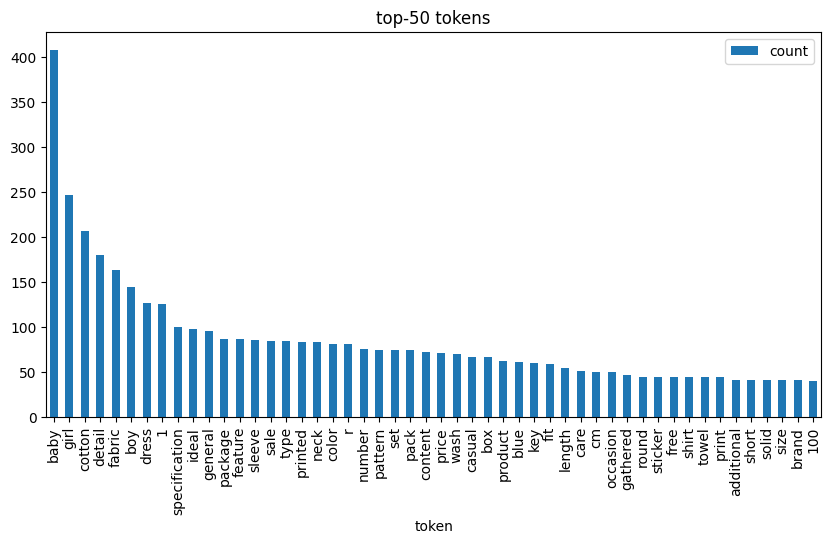

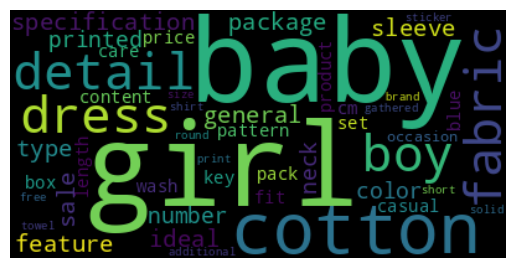

*****
beauty_and_personal_care


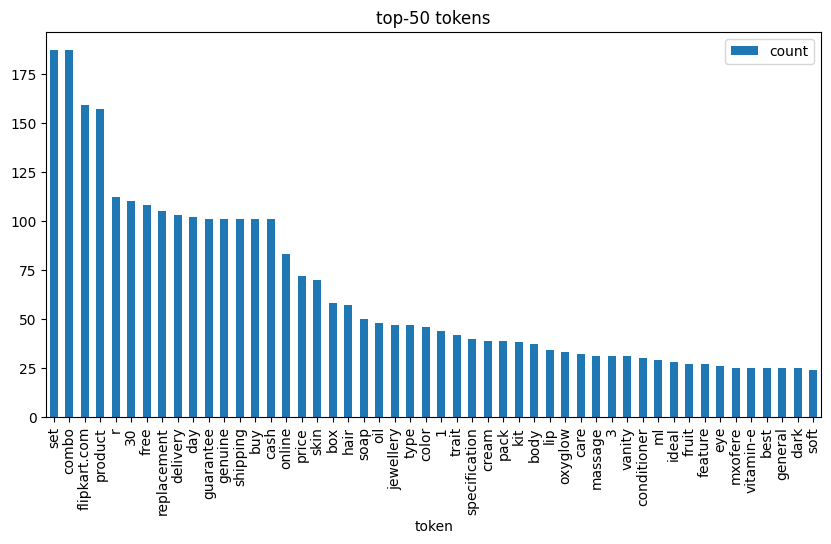

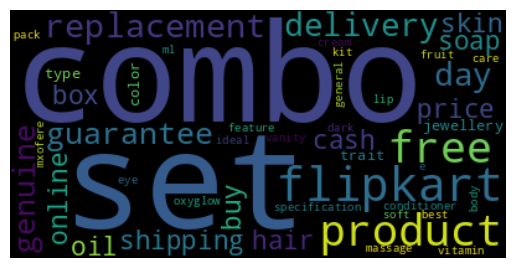

*****
computers


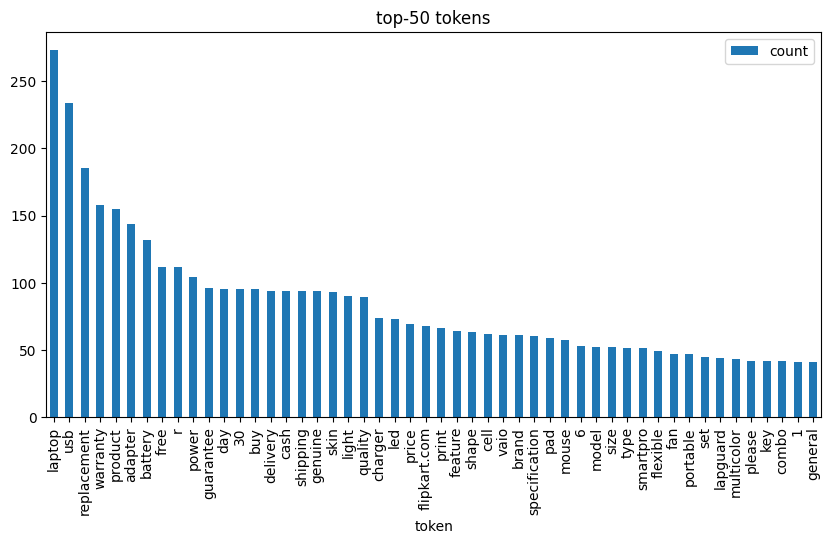

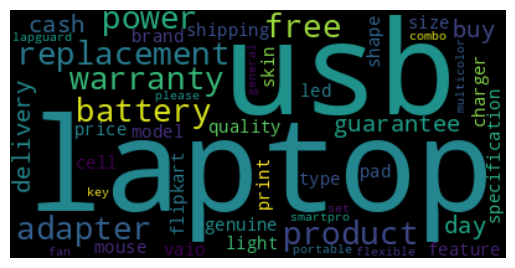

*****
home_decor_&_festive_needs


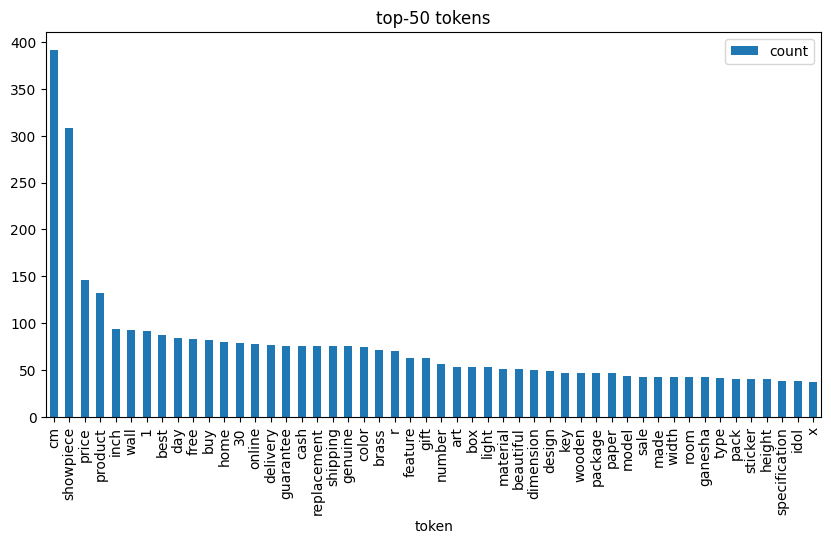

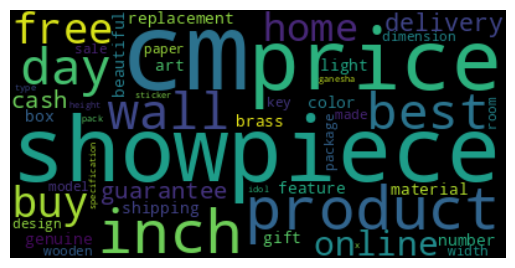

*****
home_furnishing


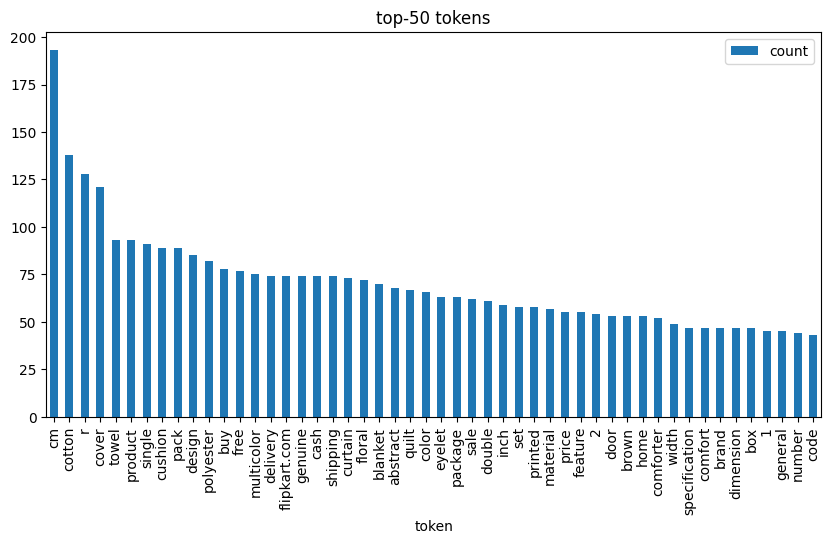

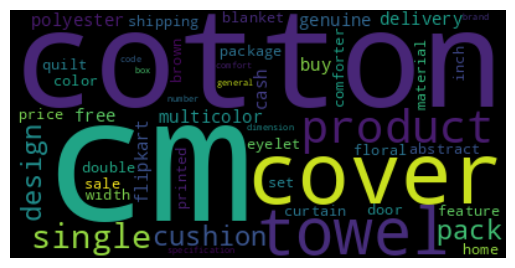

*****
kitchen_&_dining


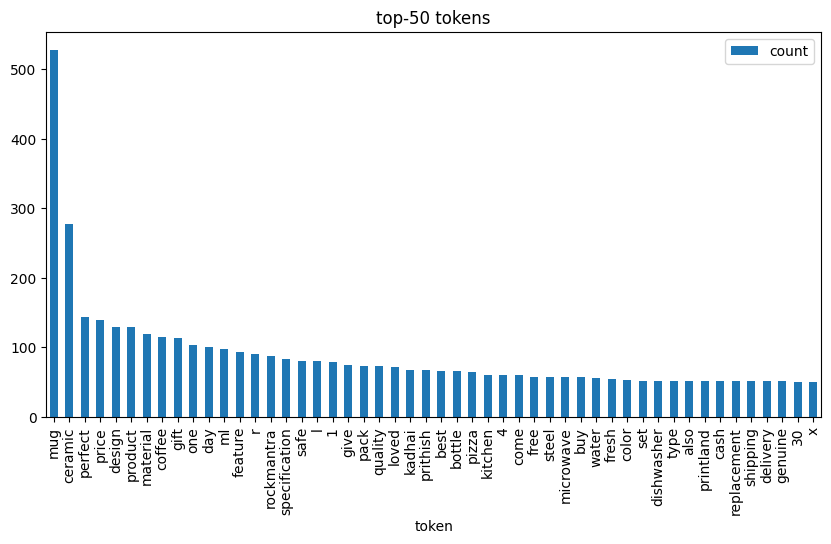

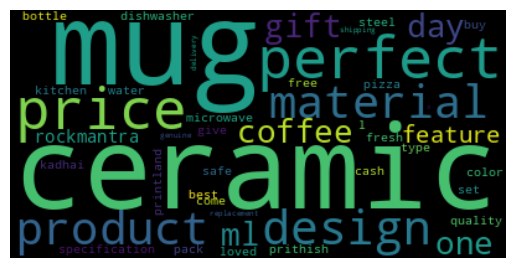

*****
watches


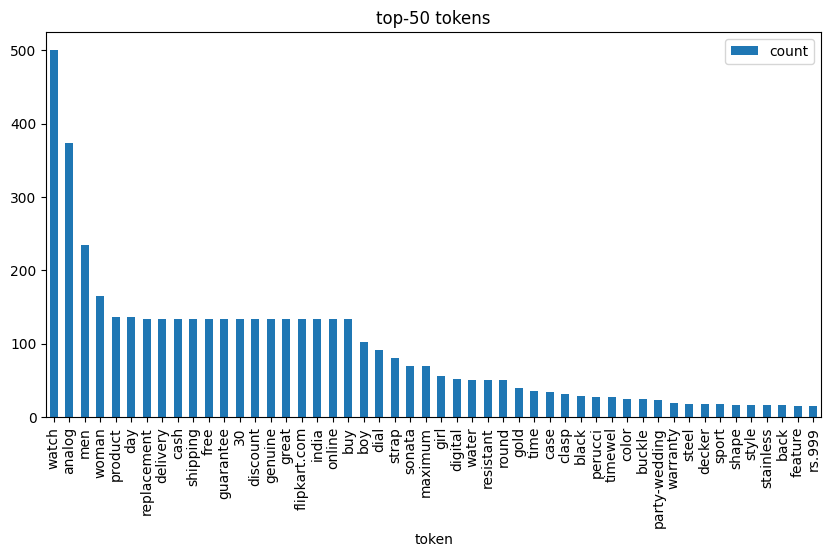

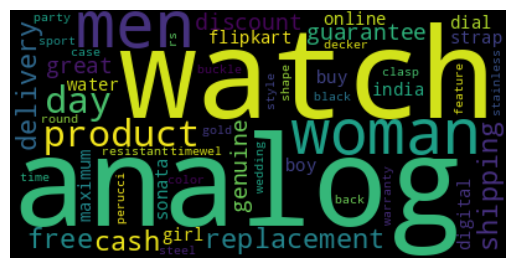

In [144]:
# Create and generate a dictionary with group_name as key and the associated
# list of the top tokens.
top_tokens = defaultdict(list)

for group_name, group in df.groupby('category').__iter__():
    print('*****')
    print(group_name)
    # display top tokens
    top_tokens[group_name] = pt.find_top_tokens(
        group, 'description_tokens', n_top=50, n_display=50, display=True
    )
    
    wordcloud = WordCloud().generate(' '.join(top_tokens[group_name]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [127]:
top_tokens[group_name]

Index(['watch', 'analog', 'men', 'woman', 'product', 'day', 'replacement',
       'delivery', 'cash', 'shipping', 'free', 'guarantee', '30', 'discount',
       'genuine', 'great', 'flipkart.com', 'india', 'online', 'buy', 'boy',
       'dial', 'strap', 'sonata', 'maximum', 'girl', 'digital', 'water',
       'resistant', 'round', 'gold', 'time', 'case', 'clasp', 'black',
       'perucci', 'timewel', 'color', 'buckle', 'party-wedding', 'warranty',
       'steel', 'decker', 'sport', 'shape', 'style', 'stainless', 'back',
       'feature', 'rs.999'],
      dtype='object', name='token')

In [136]:
from itertools import combinations

group_names = df.category.unique()
Ns = np.arange(10, 50, 10)

duplicates = defaultdict(list)

for n in Ns:
    for (a, b) in combinations(group_names, 2):
        for word in (
            set(top_tokens[a][:n]).intersection(set(top_tokens[b][:n]))
        ):
            duplicates[n].append(word)

In [139]:
duplicates[10]

['cotton',
 'product',
 'cm',
 'product',
 'design',
 'product',
 'r',
 'product',
 'r',
 'product',
 '1',
 'day',
 'product',
 'product',
 'delivery',
 'day',
 'product',
 'replacement',
 'product',
 'replacement',
 'product',
 'price',
 'day',
 'product',
 'free',
 'product',
 'free',
 'product',
 'product',
 'r',
 'product',
 'free',
 'replacement']

In [140]:
for n in Ns:
    print(f"n = {n}")
    display(pd.Series(duplicates[n]).value_counts())

n = 10


product        15
r               3
day             3
replacement     3
free            3
cotton          1
cm              1
design          1
1               1
delivery        1
price           1
Name: count, dtype: int64

n = 20


product          15
r                10
free             10
delivery         10
cash             10
genuine          10
shipping         10
buy              10
day              10
guarantee         6
30                6
replacement       6
flipkart.com      3
price             3
1                 3
online            3
design            1
feature           1
specification     1
cotton            1
cm                1
skin              1
Name: count, dtype: int64

n = 30


product          21
r                15
price            10
delivery         10
day              10
shipping         10
genuine          10
cash             10
buy              10
free             10
flipkart.com      6
1                 6
30                6
feature           6
guarantee         6
replacement       6
color             6
pack              6
online            3
box               3
specification     3
best              1
material          1
gift              1
quality           1
light             1
cotton            1
type              1
set               1
number            1
girl              1
boy               1
design            1
cm                1
inch              1
sale              1
package           1
skin              1
Name: count, dtype: int64

n = 40


product          21
price            15
free             15
r                15
buy              15
color            15
day              10
genuine          10
cash             10
delivery         10
shipping         10
feature          10
pack              6
replacement       6
specification     6
1                 6
set               6
guarantee         6
30                6
flipkart.com      6
material          3
cm                3
type              3
online            3
sale              3
box               3
design            3
package           3
best              1
water             1
gift              1
ml                1
quality           1
model             1
light             1
boy               1
care              1
number            1
key               1
round             1
girl              1
inch              1
home              1
cotton            1
printed           1
skin              1
Name: count, dtype: int64

In [151]:
# Manually extract words present in many categories in order to filter them.
# See the description_tokenizer. 
pd.Series(duplicates[40]).value_counts().index

Index(['product', 'price', 'free', 'r', 'buy', 'color', 'day', 'genuine',
       'cash', 'delivery', 'shipping', 'feature', 'pack', 'replacement',
       'specification', '1', 'set', 'guarantee', '30', 'flipkart.com',
       'material', 'cm', 'type', 'online', 'sale', 'box', 'design', 'package',
       'best', 'water', 'gift', 'ml', 'quality', 'model', 'light', 'boy',
       'care', 'number', 'key', 'round', 'girl', 'inch', 'home', 'cotton',
       'printed', 'skin'],
      dtype='object')

Even though 'cotton' appears a lot in 2 categories, I keep it because it is very discriminating from the other categories.